In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

## Data Ingestion

Before starting you can download from and find the description of data [here](https://github.com/arunism/The-Data-Science-Learning-Hub/blob/master/data/HR-Analytics.csv).

In [2]:
data = pd.read_csv('./../../data/HR-Analytics.csv')

In [3]:
data.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary,age
0,0.24,0.79,2,175,5,0,0,0,IT,low,NaN
1,0.40,0.49,2,155,3,0,1,0,hr,medium,27.0
2,0.45,0.45,2,154,3,1,1,0,support,medium,NaN
3,0.46,0.73,6,256,4,0,0,0,product_mng,high,NaN
4,0.14,0.54,5,275,4,1,0,0,sales,high,NaN


### Handling Missing Values

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15004 entries, 0 to 15003
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     15004 non-null  float64
 1   last_evaluation        15004 non-null  float64
 2   number_project         15004 non-null  int64  
 3   average_montly_hours   15004 non-null  int64  
 4   time_spend_company     15004 non-null  int64  
 5   Work_accident          15004 non-null  int64  
 6   left                   15004 non-null  object 
 7   promotion_last_5years  15004 non-null  int64  
 8   Department             15004 non-null  object 
 9   salary                 14975 non-null  object 
 10  age                    3080 non-null   float64
dtypes: float64(3), int64(5), object(3)
memory usage: 1.3+ MB


The target column `left` should have been numerical but pandas detected it to belong to object type. Let's inspect why.

In [5]:
data.left.unique()

array(['0', '1', '?'], dtype=object)

This is interesting because the target column (column to be predicted) has '?' as a value. So this needs to be handled. We will do the job in the next section.

- **NaN** (`np.nan`) is python's default marker for missing value and it stands for "Not a Number".
- We need to replace various missing values (such as empty string, ?, null, etc) with python's default missing value marker i.e. **NaN**, so that it will be easier to handle the missing values of a dataset later. Let's see two different approach to convert missing values to python's default missing value marker.

  - Approach 1: Replace the missing values **while** reading the data
    - Make a list of different missing values i.e. `missing_values = ["?", "", "n/a", "-", "--"]`
    - Pass this list in the `na_values` parameter while reading the data using pandas
      ```python
      df = pd.read_csv("HR-Analytics.csv", na_values=missing_values)
      ```

  - Approach 2: Replace the missing values **after** reading the data
    - Pandas provides a `replace()` method which can be used to replace the missing values
      ```python
      df = df.replace("?", np.nan)
      ```
  - If you want to avoid assigning the new DataFrame to the same variable you can set it "in place" using the `inplace` parameter
    ```python
    df.replace("?", np.nan, inplace=True)
    ```

In our dataset, missing values are already represented as python's default missing value marker. However, '?', '', 'n/a', '-', '--' also represent a missing value.  Let's work along considering these representations of missing data.

In [6]:
data.replace(['?', '', 'n/a', '-', '--'], np.nan, inplace=True)

In [7]:
# Check for null values
data.isna().sum()

satisfaction_level           0
last_evaluation              0
number_project               0
average_montly_hours         0
time_spend_company           0
Work_accident                0
left                         4
promotion_last_5years        0
Department                   0
salary                      29
age                      11924
dtype: int64

If there occur missing values in the target column, we drop the corresponding row to handle the missing data. In our case, we will drop the 4 rows with missing target feature values.

In [8]:
data.dropna(subset=['left'], inplace=True)

In [9]:
data.left.unique()

array(['0', '1'], dtype=object)

Typically, if a feature of a column contains more than 70% missing data, we drop the column. However this is not a rule of thumb, the exact number may vary with the domain. In our case, the 'age' column contains more than 70% of the missing values. So, we will be dropping it.

In [10]:
data.drop(columns=['age'], axis='column', inplace=True)

- If features with 'numerical' type contains missing values and if the count is quite less than 70%, we usually impute it using mean or median value.
    - Normally distributed with outlier: use median value to fill in the missing value
    - Normally distributed without outlier: use mean value to fill in the missing value

- For categorical data we mostly impute missing values using mode. In our case the 'salary' column is categorical so we will use mode to fill in missing data.

In [11]:
data.salary.fillna(data.salary.mode().values[0], inplace=True)

In [12]:
data.isna().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
Department               0
salary                   0
dtype: int64

In [13]:
data.shape

(15000, 10)

This shows that all the features with null values have been handled, and the total number of data count has been decreased to 15000. Also one of the features (age) has been removed.

## Data Exploration

<Axes: xlabel='left', ylabel='count'>

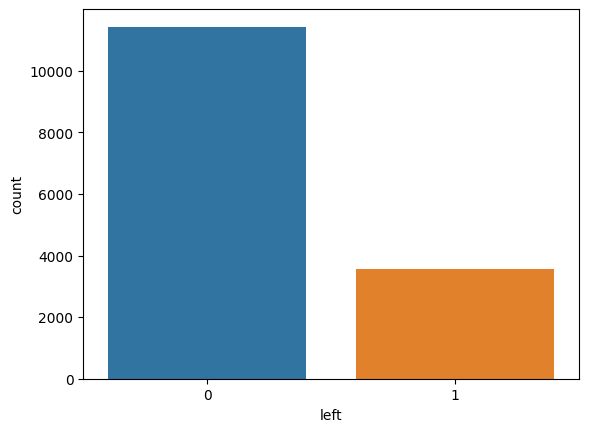

In [14]:
# Countplot over target variable
sns.countplot(x='left', data=data)

This count plot shows that given dataset is unbalanced. The dataset is dominated by negative class (0).

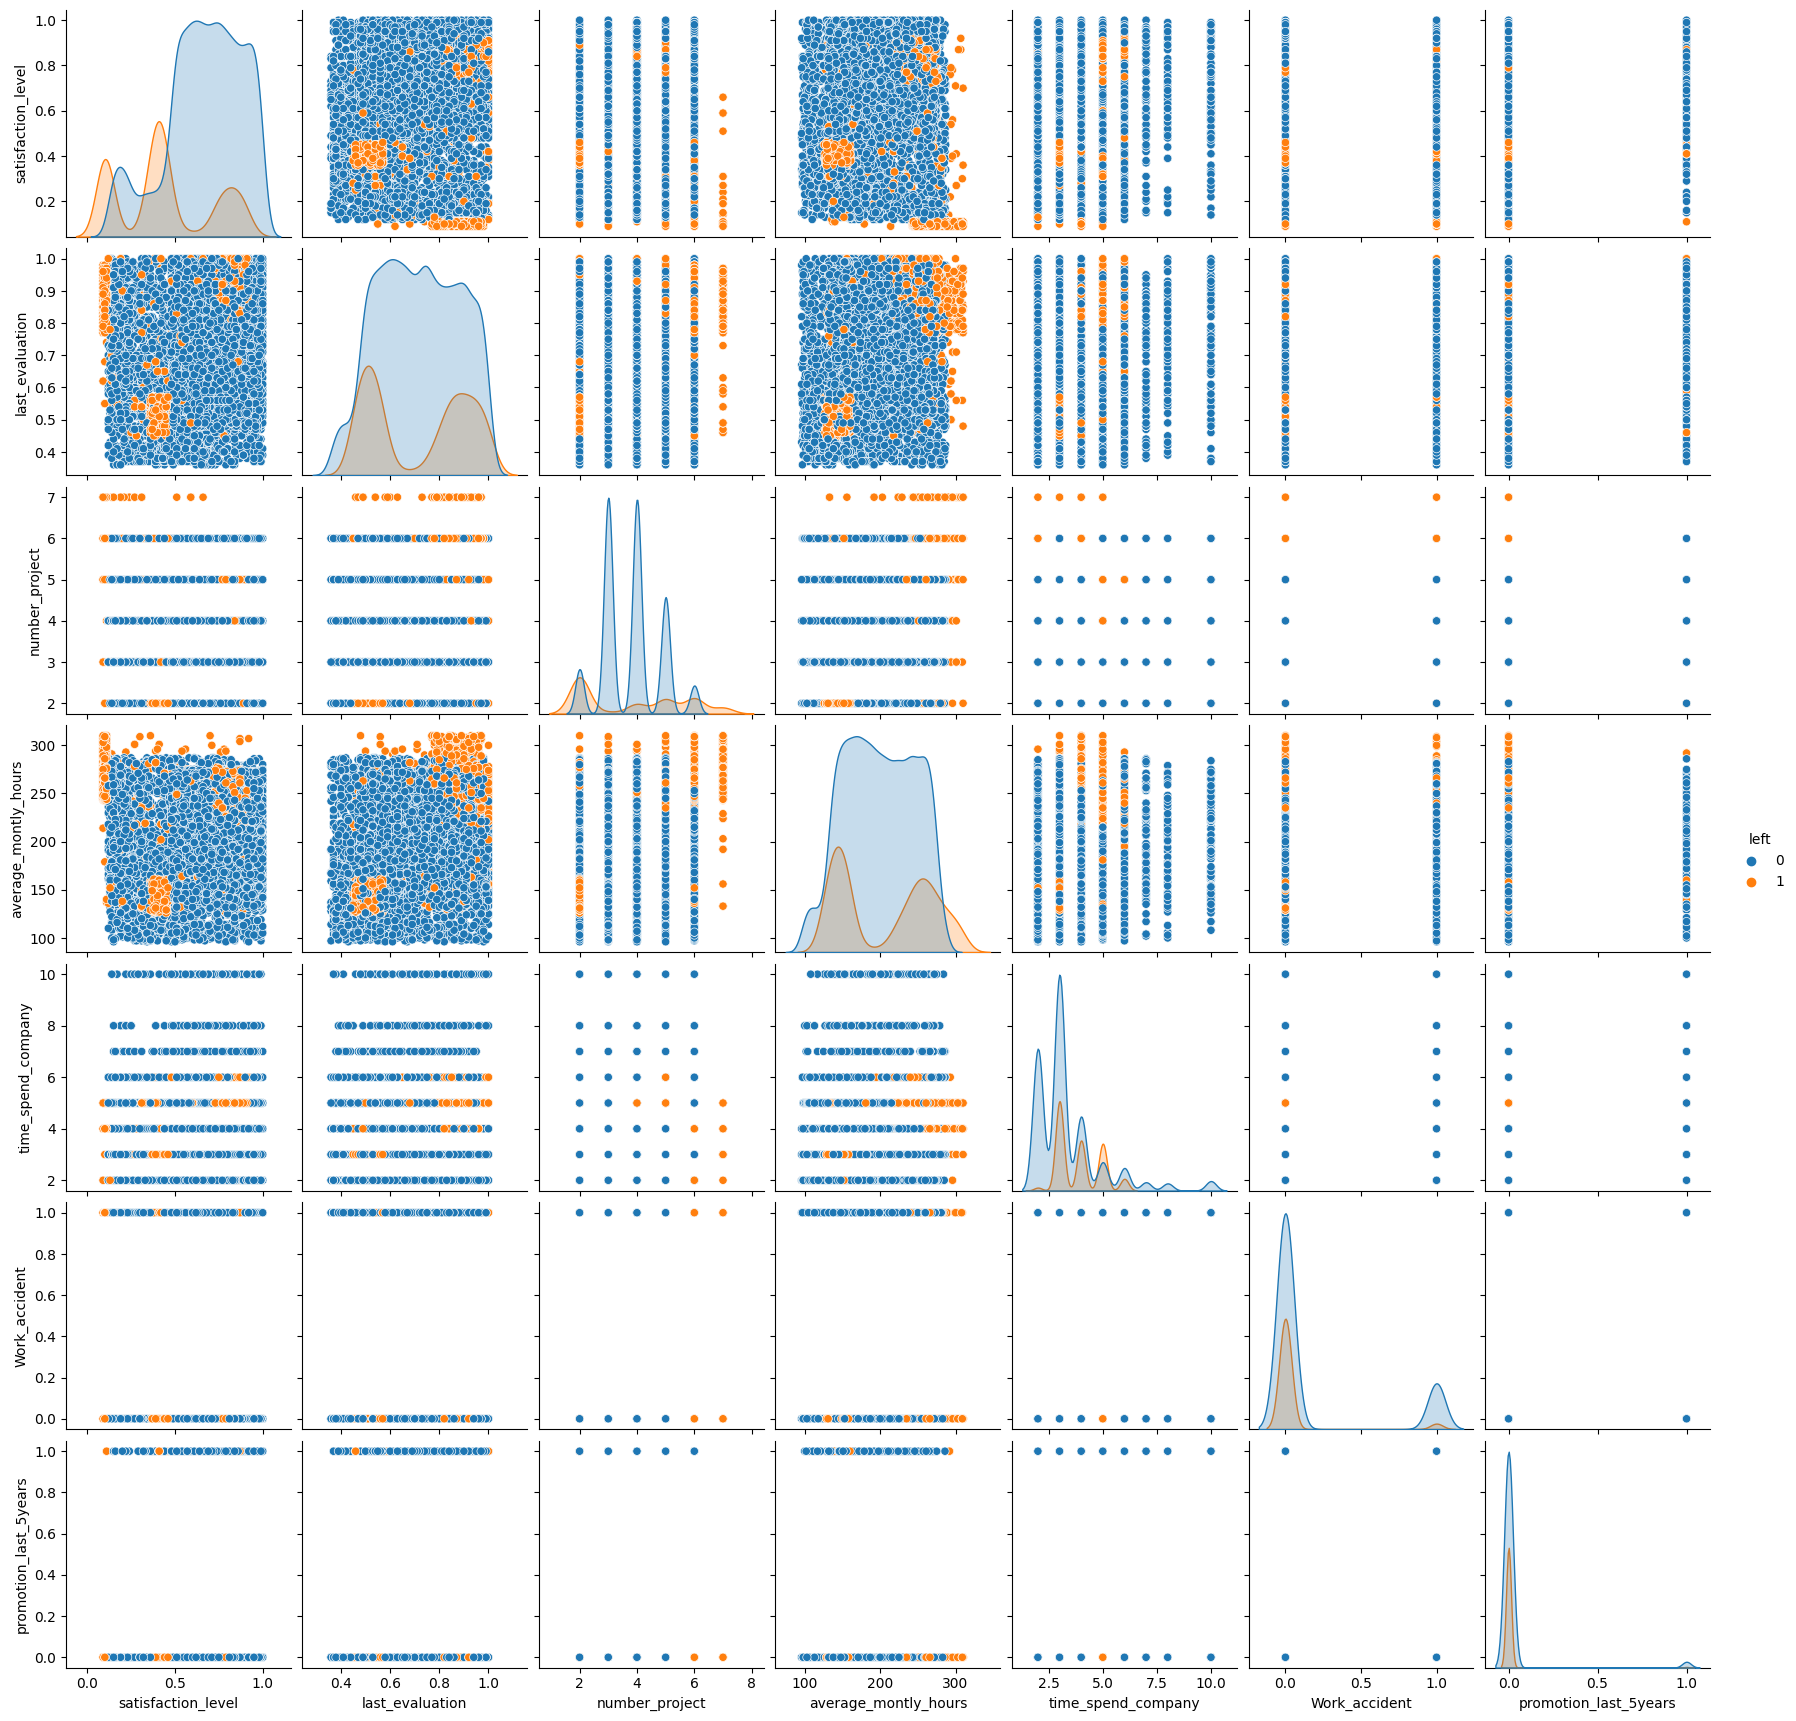

In [15]:
# Pairplot over target variable
sns.pairplot(data, hue='left')

The pairplot above is the plot of a feature against another one. The diaganol elements represent the kde plot, while all the non-diagonal elements represent the scatter plot between each indivudial features. The plots above and below the diagonal plots are mirror images of each other.

Taking any one of the scatter plot (let's take the first scatter plot) into consideration, we can see that no single line can perfectly separate the data into respective class. So, in such case non-linear models like DecisionTree, RandomForest, etc may give better result than linear models like LogisticRegression.

### Impact of Salary on Employee Retention

<Axes: xlabel='salary', ylabel='count'>

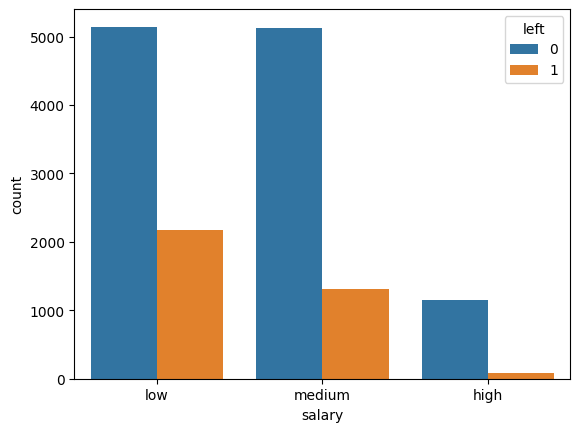

In [16]:
sns.countplot(x='salary', hue='left', data=data)

From the plot above, we can draw the insight that employee with low salary is more likely to leave the firm than the employee with medium and high salary.

### Impact of Department on Employee Retention

<Axes: xlabel='Department', ylabel='count'>

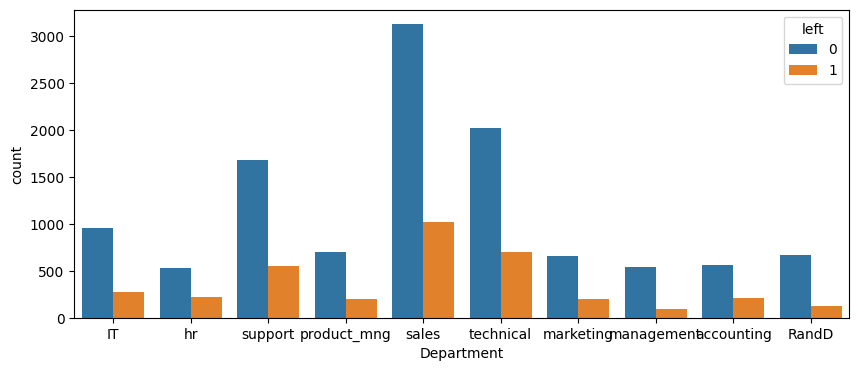

In [17]:
plt.figure(figsize = (10, 4))
sns.countplot(x="Department", hue='left', data=data)

The plot above gives an idea that the ratio of employee retention vs resignition per department is almost same. So department the employee is working for might not be a major factor for employee retention.

### Conclusion drawn from Data Exploration

From the data analysis so far we can conclude that we will use following variables as independent variables for our model:

- satisfaction_level
- average_montly_hours
- promotion_last_5years
- salary

In [18]:
data = data[['satisfaction_level','average_montly_hours','promotion_last_5years','salary', 'left']]
data.head()

,satisfaction_level,average_montly_hours,promotion_last_5years,salary,left
0,0.24,175,0,low,0
1,0.40,155,0,medium,1
2,0.45,154,0,medium,1
3,0.46,256,0,high,0
4,0.14,275,0,high,0


## Handling Categorical Variables

Salary has all text data. But our machine can only handle numerical data. So it needs to be converted to numbers, for which we will use dummy variables. This will behave same as one hot encoding.

In [19]:
salary = pd.get_dummies(data['salary'], dtype=int)
salary.head()

,high,low,medium
0,False,True,False
1,False,False,True
2,False,False,True
3,True,False,False
4,True,False,False


In [20]:
data = pd.concat([data, salary], axis='columns')
data.head()

,satisfaction_level,average_montly_hours,promotion_last_5years,salary,left,high,low,medium
0,0.24,175,0,low,0,False,True,False
1,0.40,155,0,medium,1,False,False,True
2,0.45,154,0,medium,1,False,False,True
3,0.46,256,0,high,0,True,False,False
4,0.14,275,0,high,0,True,False,False


In [21]:
data.drop(['salary'], axis=1, inplace=True)
data.head()

,satisfaction_level,average_montly_hours,promotion_last_5years,left,high,low,medium
0,0.24,175,0,0,False,True,False
1,0.40,155,0,1,False,False,True
2,0.45,154,0,1,False,False,True
3,0.46,256,0,0,True,False,False
4,0.14,275,0,0,True,False,False


## Training and Testing Model

Since this is a classification (specifically: binary classification) task, we will be using all the classification algorithms studied so far to train and test the result and finally compare the result of each algorithm with the remaining ones. Before we feed our data to these algorithms, lets make the data ready to train and test them accordingly.

In [22]:
x = data.drop('left', axis=1)
y = data['left']

Here `x` represents the training attributes while `y` represents the target variable i.e. variable to be predicted.

### Train-Test Split of Data

In [23]:
x_train, x_test , y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [24]:
del data, salary, x, y

In the above two cells, we splitted data into train and test sets. Later we deleted all the intermediate variables that we no longer need to free up memory usage.

### Train and Eval Function

In [25]:
def train(x_train, y_train, model, hyperparameters):
    """
    Arguments:
    x_train -- input features of the training set
    y_train -- target values of the training set
    model -- an instance of the model class (e.g., LogisticRegression, KNeighborsClassifier, etc.)
    hyperparameters -- dictionary of list of hyperparameter values
    
    Returns:
    best_params -- dictionary of best hyperparameters found
    best_model -- an instance of the model class with tuned hyperparameters
    """
    # Perform grid search with cross-validation
    grid_search = GridSearchCV(estimator=model, param_grid=hyperparameters, cv=5)
    grid_search.fit(x_train, y_train)
    
    # Print the best hyperparameters found
    best_params = grid_search.best_params_
    print("Best Hyperparameters:", best_params)
    
    # Train the model with best hyperparameters
    best_model = model.set_params(**best_params)
    best_model.fit(x_train, y_train)
    
    return best_params, best_model


In [26]:
def evaluate_model(x_test, y_test, best_model):
    """
    Arguments:
    best_model -- an instance of the model class with tuned hyperparameters
    x_test -- input features of the test set
    y_test -- target values of the test set
    
    Returns:
    accuracy -- accuracy score on the test set
    precision -- precision score on the test set
    recall -- recall score on the test set
    f1_score -- F1 score on the test set
    """
    
    # Predict the target values for the test set
    y_pred = best_model.predict(x_test)
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label='1')
    recall = recall_score(y_test, y_pred, pos_label='1')
    f1 = f1_score(y_test, y_pred, pos_label='1')
    
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    
    return accuracy, precision, recall, f1


### K-Nearest Neighbors (KNN)

In [27]:
hyperparameters = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
}

model = KNeighborsClassifier()
_, best_model = train(x_train, y_train, model, hyperparameters)
scores = evaluate_model(x_test, y_test, best_model)

Best Hyperparameters: {'n_neighbors': 7, 'weights': 'distance'}
Accuracy: 0.9213333333333333
Precision: 0.8154681139755766
Recall: 0.8573466476462197
F1 Score: 0.8358831710709319


### Naive Bayes Classifier

In [28]:
hyperparameters = {
    'var_smoothing': [10**(-x) for x in range(1, 11)]
}

model = GaussianNB()
_, best_model = train(x_train, y_train, model, hyperparameters)
scores = evaluate_model(x_test, y_test, best_model)

Best Hyperparameters: {'var_smoothing': 1e-05}
Accuracy: 0.8146666666666667
Precision: 0.6194398682042833
Recall: 0.536376604850214
F1 Score: 0.5749235474006117


### Logistic Regression

In [29]:
hyperparameters = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

model = LogisticRegression()
_, best_model = train(x_train, y_train, model, hyperparameters)
scores = evaluate_model(x_test, y_test, best_model)

Best Hyperparameters: {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy: 0.8063333333333333
Precision: 0.718978102189781
Recall: 0.2810271041369472
F1 Score: 0.4041025641025641


### Decision Tree Classifier

In [30]:
hyperparameters = {
    'max_depth': [3, 5, 7, 9],
    'min_samples_split': [2, 5, 10]
}

model = DecisionTreeClassifier()
_, best_model = train(x_train, y_train, model, hyperparameters)
scores = evaluate_model(x_test, y_test, best_model)

Best Hyperparameters: {'max_depth': 5, 'min_samples_split': 2}
Accuracy: 0.915
Precision: 0.9477911646586346
Recall: 0.6733238231098431
F1 Score: 0.7873227689741451


### Random Forest Classifier

In [31]:
hyperparameters = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 9],
    'min_samples_split': [2, 5, 10]
}

model = RandomForestClassifier()
_, best_model = train(x_train, y_train, model, hyperparameters)
scores = evaluate_model(x_test, y_test, best_model)

Best Hyperparameters: {'max_depth': 9, 'min_samples_split': 2, 'n_estimators': 300}
Accuracy: 0.9186666666666666
Precision: 0.9524752475247524
Recall: 0.6861626248216833
F1 Score: 0.7976782752902156


Here we did a comparative study of different classifier algorithms. Among all the five algorithms KNN gave the best result for our problem with the test f1-score of 83.5%